In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/data/upgrad/Capstone_hospital/Hospital/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks/data/upgrad/Capstone_hospital/Hospital


In [ ]:
# Imports

!pip install scikit-learn==0.24.1 category_encoders
!pip install eli5
import eli5
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option("display.max_columns", 300)
pd.set_option("display.max_rows", 300)
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import category_encoders as ce
import time
import string
import re
from scipy import sparse
from joblib import Parallel

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score,r2_score, mean_squared_error
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, chi2, f_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.utils.fixes import delayed
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import linear_model 

from  xgboost import XGBRegressor, XGBRFRegressor, plot_importance
from  xgboost import XGBClassifier

In [ ]:
# Defining functions to use in EDA and printing scores

# Function to plot categorical variables

def plot_categorical(data,categorical_var,target_var,label_rotation=45,combine_less_freq_segments_pct = 0):
  data2 = data.copy()
  series = pd.value_counts(data2[categorical_var])
  if combine_less_freq_segments_pct > 0:
    mask = (series/series.sum() * 100).lt(combine_less_freq_segments_pct)
    data2[categorical_var] = np.where(data2[categorical_var].isin(series[mask].index),'All Others',data2[categorical_var])

  fig, axes = plt.subplots(nrows=1, ncols=2)

  data2.groupby(categorical_var)["Hospital overall rating"].count().sort_values().plot(kind = "pie", figsize=(10,10), autopct='%1.f%%', ax=axes[0]).set_ylabel('')

  data2.groupby(categorical_var)[target_var].mean().dropna().sort_values().plot(kind='bar',figsize=(20,6), rot=label_rotation, ax=axes[1])
  axes[1].set(ylabel='Avg Overall Rating')



# Function to plot numeric variables

def plot_numerical(data,numerical_var,target_var):
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,6))
  fig.tight_layout(pad=5.0)

  sns.distplot(data[numerical_var], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3}, ax=axes[0])
  
  data[numerical_var].dropna().plot(kind = "box", ax = axes[1]) #, figsize = (20,10)

  sns.boxplot(x=target_var, y=numerical_var, data=data, ax=axes[2],showfliers = False)

# Introduction

*Hospital Compare* is a consumer-oriented website that provides information on how well hospitals provide recommended care to their patients. *Hospital Compare* allows consumers to select multiple hospitals and directly compare performance measure information related to heart attack, heart failure, pneumonia, surgery and other conditions. These results are organized by:

* General information
* Survey of patients' experiences
* Timely & effective care
* Complications
* Readmissions & deaths
* Use of medical imaging
* Payment & value of care

### Importing dataframes that are useful for calculating performance score

# Importing and Cleaning Datasets

In [ ]:
# Replacing elements in nan_words list with NaN value in all the dataframes
nan_words = ["", "Not Applicable" , "Not Available","nan"]

gen_info = pd.read_csv("Hospital General Information.csv" , encoding= 'unicode_escape', na_values= nan_words )  

hcahps = pd.read_csv("HCAHPS - Hospital.csv" , encoding= 'unicode_escape', na_values = nan_words) 

readmsns_deaths =  pd.read_csv("Readmissions and Deaths - Hospital.csv" , na_values = nan_words)

timely_eff_care =  pd.read_csv("Timely and Effective Care - Hospital.csv" , na_values = nan_words) 

complications =  pd.read_csv("Complications - Hospital.csv" , na_values = nan_words)  

op_img_eff =  pd.read_csv("Outpatient Imaging Efficiency - Hospital.csv" , na_values = nan_words)  

pmt_care_value =  pd.read_csv("Payment and Value of Care - Hospital.csv" , encoding= 'unicode_escape', na_values = nan_words)  

# gen_info (Hospital General Information)      

In [ ]:
gen_info.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,Emergency Services,Meets criteria for meaningful use of EHRs,Hospital overall rating,Hospital overall rating footnote,Mortality national comparison,Mortality national comparison footnote,Safety of care national comparison,Safety of care national comparison footnote,Readmission national comparison,Readmission national comparison footnote,Patient experience national comparison,Patient experience national comparison footnote,Effectiveness of care national comparison,Effectiveness of care national comparison footnote,Timeliness of care national comparison,Timeliness of care national comparison footnote,Efficient use of medical imaging national comparison,Efficient use of medical imaging national comparison footnote
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3.0,NaN,Same as the National average,NaN,Above the National average,NaN,Same as the National average,NaN,Below the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Same as the National average,NaN
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3.0,NaN,Below the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Below the National average,NaN
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,2.0,NaN,Below the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Below the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Same as the National average,NaN
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Y,3.0,NaN,Same as the National average,NaN,Same as the National average,NaN,Below the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Above the National average,NaN,NaN,Results are not available for this reporting p...
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,Acute Care Hospitals,Proprietary,Yes,Y,3.0,NaN,Same as the National average,NaN,NaN,Results are not available for this reporting p...,Same as the National average,NaN,NaN,Results are not available for this reporting p...,Same as the National average,NaN,Above the National average,NaN,NaN,Results are not available for this reporting p...


In [ ]:
# Dropping unusable columns
common_droplist = ["County Name","Hospital Name","Address","City","ZIP Code","Phone Number"]
gen_info = gen_info.drop(common_droplist, axis = 1)

# Setting Provider ID as the index
gen_info = gen_info.set_index("Provider ID")

gen_info.head()

,State,Hospital Type,Hospital Ownership,Emergency Services,Meets criteria for meaningful use of EHRs,Hospital overall rating,Hospital overall rating footnote,Mortality national comparison,Mortality national comparison footnote,Safety of care national comparison,Safety of care national comparison footnote,Readmission national comparison,Readmission national comparison footnote,Patient experience national comparison,Patient experience national comparison footnote,Effectiveness of care national comparison,Effectiveness of care national comparison footnote,Timeliness of care national comparison,Timeliness of care national comparison footnote,Efficient use of medical imaging national comparison,Efficient use of medical imaging national comparison footnote
Provider ID,,,,,,,,,,,,,,,,,,,,,
10001,AL,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3.0,NaN,Same as the National average,NaN,Above the National average,NaN,Same as the National average,NaN,Below the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Same as the National average,NaN
10005,AL,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3.0,NaN,Below the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Below the National average,NaN
10006,AL,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,2.0,NaN,Below the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Below the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Same as the National average,NaN
10007,AL,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Y,3.0,NaN,Same as the National average,NaN,Same as the National average,NaN,Below the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Above the National average,NaN,NaN,Results are not available for this reporting p...
10008,AL,Acute Care Hospitals,Proprietary,Yes,Y,3.0,NaN,Same as the National average,NaN,NaN,Results are not available for this reporting p...,Same as the National average,NaN,NaN,Results are not available for this reporting p...,Same as the National average,NaN,Above the National average,NaN,NaN,Results are not available for this reporting p...


# hcahps (HCAHPS - Hospital)

In [ ]:
hcahps.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,HCAHPS Measure ID,HCAHPS Question,HCAHPS Answer Description,Patient Survey Star Rating,Patient Survey Star Rating Footnote,HCAHPS Answer Percent,HCAHPS Answer Percent Footnote,HCAHPS Linear Mean Value,Number of Completed Surveys,Number of Completed Surveys Footnote,Survey Response Rate Percent,Survey Response Rate Percent Footnote,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,H_STAR_RATING,Summary star rating,Summary star rating,3.0,NaN,NaN,NaN,NaN,1194,NaN,27.0,NaN,01/01/2015,12/31/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,H_CLEAN_HSP_A_P,Patients who reported that their room and bath...,"Room was ""always"" clean",NaN,NaN,66.0,NaN,NaN,1194,NaN,27.0,NaN,01/01/2015,12/31/2015
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,H_CLEAN_HSP_SN_P,Patients who reported that their room and bath...,"Room was ""sometimes"" or ""never"" clean",NaN,NaN,12.0,NaN,NaN,1194,NaN,27.0,NaN,01/01/2015,12/31/2015
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,H_CLEAN_HSP_U_P,Patients who reported that their room and bath...,"Room was ""usually"" clean",NaN,NaN,22.0,NaN,NaN,1194,NaN,27.0,NaN,01/01/2015,12/31/2015
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,H_CLEAN_LINEAR_SCORE,Cleanliness - linear mean score,Cleanliness - linear mean score,NaN,NaN,NaN,NaN,84.0,1194,NaN,27.0,NaN,01/01/2015,12/31/2015


In [ ]:
# Dropping unusable columns
common_droplist = ["Hospital Name", "Address","City", "State", "ZIP Code", "County Name", "Phone Number","Measure Start Date", "Measure End Date"]
hcahps_droplist = ["HCAHPS Question", "HCAHPS Answer Description" , "Patient Survey Star Rating Footnote",
                   "HCAHPS Answer Percent Footnote","Number of Completed Surveys Footnote","Survey Response Rate Percent Footnote","Number of Completed Surveys",
                   "Survey Response Rate Percent"]
hcahps = hcahps.drop(common_droplist + hcahps_droplist , axis = 1)


# Converting data from long format to wide format using pivot
hcahps = hcahps.pivot(index='Provider ID',columns='HCAHPS Measure ID', values = ['HCAHPS Answer Percent','Patient Survey Star Rating','HCAHPS Linear Mean Value'])
hcahps.columns = ['{}_{}'.format(j,i) for i,j in hcahps.columns]

hcahps.head()

,H_CLEAN_HSP_A_P_HCAHPS Answer Percent,H_CLEAN_HSP_SN_P_HCAHPS Answer Percent,H_CLEAN_HSP_U_P_HCAHPS Answer Percent,H_CLEAN_LINEAR_SCORE_HCAHPS Answer Percent,H_CLEAN_STAR_RATING_HCAHPS Answer Percent,H_COMP_1_A_P_HCAHPS Answer Percent,H_COMP_1_LINEAR_SCORE_HCAHPS Answer Percent,H_COMP_1_SN_P_HCAHPS Answer Percent,H_COMP_1_STAR_RATING_HCAHPS Answer Percent,H_COMP_1_U_P_HCAHPS Answer Percent,H_COMP_2_A_P_HCAHPS Answer Percent,H_COMP_2_LINEAR_SCORE_HCAHPS Answer Percent,H_COMP_2_SN_P_HCAHPS Answer Percent,H_COMP_2_STAR_RATING_HCAHPS Answer Percent,H_COMP_2_U_P_HCAHPS Answer Percent,H_COMP_3_A_P_HCAHPS Answer Percent,H_COMP_3_LINEAR_SCORE_HCAHPS Answer Percent,H_COMP_3_SN_P_HCAHPS Answer Percent,H_COMP_3_STAR_RATING_HCAHPS Answer Percent,H_COMP_3_U_P_HCAHPS Answer Percent,H_COMP_4_A_P_HCAHPS Answer Percent,H_COMP_4_LINEAR_SCORE_HCAHPS Answer Percent,H_COMP_4_SN_P_HCAHPS Answer Percent,H_COMP_4_STAR_RATING_HCAHPS Answer Percent,H_COMP_4_U_P_HCAHPS Answer Percent,H_COMP_5_A_P_HCAHPS Answer Percent,H_COMP_5_LINEAR_SCORE_HCAHPS Answer Percent,H_COMP_5_SN_P_HCAHPS Answer Percent,H_COMP_5_STAR_RATING_HCAHPS Answer Percent,H_COMP_5_U_P_HCAHPS Answer Percent,H_COMP_6_LINEAR_SCORE_HCAHPS Answer Percent,H_COMP_6_N_P_HCAHPS Answer Percent,H_COMP_6_STAR_RATING_HCAHPS Answer Percent,H_COMP_6_Y_P_HCAHPS Answer Percent,H_COMP_7_A_HCAHPS Answer Percent,H_COMP_7_D_SD_HCAHPS Answer Percent,H_COMP_7_LINEAR_SCORE_HCAHPS Answer Percent,H_COMP_7_SA_HCAHPS Answer Percent,H_COMP_7_STAR_RATING_HCAHPS Answer Percent,H_HSP_RATING_0_6_HCAHPS Answer Percent,H_HSP_RATING_7_8_HCAHPS Answer Percent,H_HSP_RATING_9_10_HCAHPS Answer Percent,H_HSP_RATING_LINEAR_SCORE_HCAHPS Answer Percent,H_HSP_RATING_STAR_RATING_HCAHPS Answer Percent,H_QUIET_HSP_A_P_HCAHPS Answer Percent,H_QUIET_HSP_SN_P_HCAHPS Answer Percent,H_QUIET_HSP_U_P_HCAHPS Answer Percent,H_QUIET_LINEAR_SCORE_HCAHPS Answer Percent,H_QUIET_STAR_RATING_HCAHPS Answer Percent,H_RECMND_DN_HCAHPS Answer Percent,H_RECMND_DY_HCAHPS Answer Percent,H_RECMND_LINEAR_SCORE_HCAHPS Answer Percent,H_RECMND_PY_HCAHPS Answer Percent,H_RECMND_STAR_RATING_HCAHPS Answer Percent,H_STAR_RATING_HCAHPS Answer Percent,H_CLEAN_HSP_A_P_Patient Survey Star Rating,H_CLEAN_HSP_SN_P_Patient Survey Star Rating,H_CLEAN_HSP_U_P_Patient Survey Star Rating,H_CLEAN_LINEAR_SCORE_Patient Survey Star Rating,H_CLEAN_STAR_RATING_Patient Survey Star Rating,H_COMP_1_A_P_Patient Survey Star Rating,H_COMP_1_LINEAR_SCORE_Patient Survey Star Rating,H_COMP_1_SN_P_Patient Survey Star Rating,H_COMP_1_STAR_RATING_Patient Survey Star Rating,H_COMP_1_U_P_Patient Survey Star Rating,H_COMP_2_A_P_Patient Survey Star Rating,H_COMP_2_LINEAR_SCORE_Patient Survey Star Rating,H_COMP_2_SN_P_Patient Survey Star Rating,H_COMP_2_STAR_RATING_Patient Survey Star Rating,H_COMP_2_U_P_Patient Survey Star Rating,H_COMP_3_A_P_Patient Survey Star Rating,H_COMP_3_LINEAR_SCORE_Patient Survey Star Rating,H_COMP_3_SN_P_Patient Survey Star Rating,H_COMP_3_STAR_RATING_Patient Survey Star Rating,H_COMP_3_U_P_Patient Survey Star Rating,H_COMP_4_A_P_Patient Survey Star Rating,H_COMP_4_LINEAR_SCORE_Patient Survey Star Rating,H_COMP_4_SN_P_Patient Survey Star Rating,H_COMP_4_STAR_RATING_Patient Survey Star Rating,H_COMP_4_U_P_Patient Survey Star Rating,H_COMP_5_A_P_Patient Survey Star Rating,H_COMP_5_LINEAR_SCORE_Patient Survey Star Rating,H_COMP_5_SN_P_Patient Survey Star Rating,H_COMP_5_STAR_RATING_Patient Survey Star Rating,H_COMP_5_U_P_Patient Survey Star Rating,H_COMP_6_LINEAR_SCORE_Patient Survey Star Rating,H_COMP_6_N_P_Patient Survey Star Rating,H_COMP_6_STAR_RATING_Patient Survey Star Rating,H_COMP_6_Y_P_Patient Survey Star Rating,H_COMP_7_A_Patient Survey Star Rating,H_COMP_7_D_SD_Patient Survey Star Rating,H_COMP_7_LINEAR_SCORE_Patient Survey Star Rating,H_COMP_7_SA_Patient Survey Star Rating,H_COMP_7_STAR_RATING_Patient Survey Star Rating,H_HSP_RATING_0_6_Patient Survey Star Rating,H_HSP_RATING_7_8_Patient Survey Star Rating,H_HSP_RATING_9_10_Patient Survey Star Rating,H_HSP_RAT

# readmsns_deaths (Readmissions and Deaths) 

In [ ]:
readmsns_deaths.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Measure Name,Measure ID,Compared to National,Denominator,Score,Lower Estimate,Higher Estimate,Footnote,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Myocardial Infarction (AMI) 30-Day Morta...,MORT_30_AMI,No Different than the National Rate,733.0,12.5,10.6,14.9,NaN,07/01/2012,06/30/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Death rate for CABG,MORT_30_CABG,No Different than the National Rate,278.0,4.2,2.6,6.8,NaN,07/01/2012,06/30/2015
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Death rate for chronic obstructive pulmonary d...,MORT_30_COPD,No Different than the National Rate,586.0,9.3,7.3,11.8,NaN,07/01/2012,06/30/2015
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Heart failure (HF) 30-Day Mortality Rate,MORT_30_HF,No Different than the National Rate,797.0,12.4,10.4,14.6,NaN,07/01/2012,06/30/2015
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Pneumonia (PN) 30-Day Mortality Rate,MORT_30_PN,No Different than the National Rate,599.0,15.5,13.0,18.5,NaN,07/01/2012,06/30/2015


In [ ]:
# Dropping unusable columns
common_droplist = ["Hospital Name", "Address","City", "State", "ZIP Code", "County Name", "Phone Number","Measure Start Date", "Measure End Date"]
readmsns_deaths_droplist = ["Footnote","Measure Name", "Compared to National", "Higher Estimate","Lower Estimate",'Denominator']
readmsns_deaths = readmsns_deaths.drop(common_droplist + readmsns_deaths_droplist , axis = 1)


# Converting data from long format to wide format using pivot
readmsns_deaths = readmsns_deaths.pivot(index='Provider ID',columns='Measure ID', values = ['Score'])
readmsns_deaths.columns = ['{}_{}'.format(j,i) for i,j in readmsns_deaths.columns]

readmsns_deaths.head()

,MORT_30_AMI_Score,MORT_30_CABG_Score,MORT_30_COPD_Score,MORT_30_HF_Score,MORT_30_PN_Score,MORT_30_STK_Score,READM_30_AMI_Score,READM_30_CABG_Score,READM_30_COPD_Score,READM_30_HF_Score,READM_30_HIP_KNEE_Score,READM_30_HOSP_WIDE_Score,READM_30_PN_Score,READM_30_STK_Score
Provider ID,,,,,,,,,,,,,,
10001,12.5,4.2,9.3,12.4,15.5,15.4,16.5,15.1,21.1,21.4,5.1,15.4,18.7,12.7
10005,16.0,NaN,7.6,15.5,20.8,15.5,16.7,NaN,18.0,21.9,5.7,14.9,16.4,13.4
10006,16.7,4.1,7.1,15.6,18.2,17.9,16.1,15.2,19.8,20.6,5.0,15.4,17.9,12.0
10007,NaN,NaN,9.3,14.4,18.8,16.6,NaN,NaN,19.9,21.1,NaN,16.6,17.3,12.7
10008,NaN,NaN,8.2,12.7,15.7,NaN,NaN,NaN,19.2,23.1,NaN,15.7,16.0,NaN


# timely_eff_care (Timely and Effective Care - Hospital) 

In [ ]:
timely_eff_care.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Condition,Measure ID,Measure Name,Score,Sample,Footnote,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Heart Attack or Chest Pain,AMI_7a,Fibrinolytic Therapy Received Within 30 Minute...,NaN,NaN,7 - No cases met the criteria for this measure.,01/01/2015,12/31/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Heart Attack or Chest Pain,AMI_8a,Primary PCI Received Within 90 Minutes of Hosp...,92,24.0,3 - Results are based on a shorter time period...,01/01/2015,09/30/2015
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Children's Asthma,CAC_3,Home Management Plan of Care Document,NaN,NaN,5 - Results are not available for this reporti...,01/01/2015,12/31/2015
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Emergency Department,ED_1b,ED1,269,535.0,2 - Data submitted were based on a sample of c...,01/01/2015,12/31/2015
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Emergency Department,ED_2b,ED2,68,535.0,2 - Data submitted were based on a sample of c...,01/01/2015,12/31/2015


In [ ]:
# Dropping unusable columns
common_droplist = ["Hospital Name", "Address","City", "State", "ZIP Code", "County Name", "Phone Number","Measure Start Date", "Measure End Date"]
timely_eff_care_droplist = ["Measure Name", "Condition","Footnote"]
timely_eff_care = timely_eff_care.drop(common_droplist + timely_eff_care_droplist , axis = 1)

# Converting data from long format to wide format using pivot
timely_eff_care = timely_eff_care.pivot(index='Provider ID', columns='Measure ID', values = ['Score','Sample'])
timely_eff_care.columns = ['{}_{}'.format(j,i) for i,j in timely_eff_care.columns]

# Extracting first few useful words from Score_EDV
timely_eff_care["EDV_Score"] = timely_eff_care["EDV_Score"].str.split('(', 1,expand=True)[0].str.strip()

timely_eff_care.head()

,AMI_7a_Score,AMI_8a_Score,CAC_3_Score,EDV_Score,ED_1b_Score,ED_2b_Score,HF_2_Score,IMM_2_Score,IMM_3_OP_27_FAC_ADHPCT_Score,OP_1_Score,OP_18b_Score,OP_2_Score,OP_20_Score,OP_21_Score,OP_22_Score,OP_23_Score,OP_29_Score,OP_30_Score,OP_3b_Score,OP_4_Score,OP_5_Score,PC_01_Score,PN_6_Score,SCIP_CARD_2_Score,SCIP_INF_1_Score,SCIP_INF_2_Score,SCIP_INF_3_Score,SCIP_INF_9_Score,SCIP_VTE_2_Score,STK_1_Score,STK_10_Score,STK_2_Score,STK_3_Score,STK_4_Score,STK_5_Score,STK_6_Score,STK_8_Score,VTE_1_Score,VTE_2_Score,VTE_3_Score,VTE_4_Score,VTE_5_Score,VTE_6_Score,AMI_7a_Sample,AMI_8a_Sample,CAC_3_Sample,EDV_Sample,ED_1b_Sample,ED_2b_Sample,HF_2_Sample,IMM_2_Sample,IMM_3_OP_27_FAC_ADHPCT_Sample,OP_1_Sample,OP_18b_Sample,OP_2_Sample,OP_20_Sample,OP_21_Sample,OP_22_Sample,OP_23_Sample,OP_29_Sample,OP_30_Sample,OP_3b_Sample,OP_4_Sample,OP_5_Sample,PC_01_Sample,PN_6_Sample,SCIP_CARD_2_Sample,SCIP_INF_1_Sample,SCIP_INF_2_Sample,SCIP_INF_3_Sample,SCIP_INF_9_Sample,SCIP_VTE_2_Sample,STK_1_Sample,STK_10_Sample,STK_2_Sample,STK_3_Sample,STK_4_Sample,STK_5_Sample,STK_6_Sample,STK_8_Sample,VTE_1_Sample,VTE_2_Sample,VTE_3_Sample,VTE_4_Sample,VTE_5_Sample,VTE_6_Sample
Provider ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10001,NaN,92,NaN,High,269,68,100,97,81,NaN,196,NaN,65,99,4,NaN,NaN,82,NaN,NaN,NaN,0,98,98,100,100,99,96,100,99,96,100,NaN,67,98,99,87,97,99,91,NaN,90,0,NaN,24,NaN,NaN,535,535,337,537,3791,NaN,371,NaN,377,111,58662,NaN,NaN,72,NaN,NaN,NaN,36,104,94,174,174,170,165,150,133,54,46,NaN,12,48,99,75,409,102,88,NaN,59,19
10005,NaN,NaN,NaN,Very High,243,71,97,99,83,NaN,117,NaN,27,60,2,86,92,92,NaN,99,12,1,98,100,100,99,100,100,100,98,99,100,100,NaN,99,88,100,95,94,100,100,100,NaN,NaN,NaN,NaN,NaN,1258,1116,164,914,1665,NaN,1405,NaN,1407,290,67953,14,63,64,NaN,225,236,196,131,86,284,284,282,234,281,130,93,89,11,NaN,94,86,63,461,124,26,23,16,NaN
10006,NaN,NaN,NaN,High,217,78,NaN,100,87,NaN,133,NaN,10,58,1,NaN,70,88,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99,100,100,94,NaN,99,97,90,98,89,86,100,92,0,NaN,NaN,NaN,NaN,527,466,NaN,518,2075,NaN,359,NaN,379,97,41382,NaN,69,66,NaN,NaN,NaN,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,142,88,72,16,NaN,80,91,62,417,111,69,45,40,14
10007,NaN,NaN,NaN,Low,219,68,97,99,53,NaN,119,NaN,38,90,1,NaN,0,0,NaN,89,7,NaN,84,80,100,100,94,85,100,80,85,100,NaN,NaN,100,71,NaN,97,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,457,453,38,287,300,NaN,560,NaN,639,29,11548,NaN,100,55,NaN,35,35,NaN,37,15,35,35,34,40,38,20,13,12,NaN,NaN,11,14,NaN,292,77,NaN,NaN,NaN,NaN
10008,NaN,NaN,NaN,Low,180,56,100,95,43,NaN,98,NaN,27,49,1,NaN,96,97,NaN,NaN,NaN,NaN,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,531,531,18,292,207,NaN,372,NaN,384,39,6518,NaN,48,38,NaN,NaN,NaN,NaN,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,178,NaN,NaN,NaN,NaN,NaN


# complications (Complications - Hospital) 

In [ ]:
complications.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Measure Name,Measure ID,Compared to National,Denominator,Score,Lower Estimate,Higher Estimate,Footnote,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Rate of complications for hip/knee replacement...,COMP_HIP_KNEE,No Different than the National Rate,331.0,3.80,2.60,5.50,NaN,04/01/2012,03/31/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Serious blood clots after surgery,PSI_12_POSTOP_PULMEMB_DVT,No Different than the National Rate,4549.0,3.32,1.25,5.38,NaN,07/01/2013,06/30/2015
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Blood stream infection after surgery,PSI_13_POST_SEPSIS,No Different than the National Rate,578.0,5.72,0.00,11.48,NaN,07/01/2013,06/30/2015
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,A wound that splits open after surgery on the...,PSI_14_POSTOP_DEHIS,No Different than the National Rate,445.0,2.72,0.65,4.79,NaN,07/01/2013,06/30/2015
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Accidental cuts and tears from medical treatment,PSI_15_ACC_LAC,No Different than the National Rate,16429.0,1.35,0.76,1.95,NaN,07/01/2013,06/30/2015


In [ ]:
# Dropping unusable columns
common_droplist = ["Hospital Name", "Address","City", "State", "ZIP Code", "County Name", "Phone Number","Measure Start Date", "Measure End Date"]
complications_droplist = ["Measure Name", "Footnote","Compared to National","Lower Estimate", "Higher Estimate",'Denominator']
complications = complications.drop(common_droplist + complications_droplist , axis = 1)

# Converting data from long format to wide format using pivot
complications = complications.pivot(index='Provider ID',columns='Measure ID', values = ['Score'])
complications.columns = ['{}_{}'.format(j,i) for i,j in complications.columns]

complications.head()

,COMP_HIP_KNEE_Score,PSI_12_POSTOP_PULMEMB_DVT_Score,PSI_13_POST_SEPSIS_Score,PSI_14_POSTOP_DEHIS_Score,PSI_15_ACC_LAC_Score,PSI_3_ULCER_Score,PSI_4_SURG_COMP_Score,PSI_6_IAT_PTX_Score,PSI_7_CVCBI_Score,PSI_8_POST_HIP_Score,PSI_90_SAFETY_Score
Provider ID,,,,,,,,,,,
10001,3.8,3.32,5.72,2.72,1.35,0.07,168.26,0.36,0.12,0.06,0.68
10005,3.0,5.63,9.18,2.11,1.25,0.14,179.05,0.47,0.11,0.06,0.85
10006,3.8,3.85,NaN,2.50,1.93,0.09,198.33,0.41,0.24,0.06,0.91
10007,NaN,4.57,9.89,NaN,1.20,0.35,NaN,0.40,0.16,0.06,0.79
10008,NaN,NaN,NaN,NaN,1.41,0.45,NaN,0.41,0.17,NaN,0.90


# op_img_eff (Outpatient Imaging Efficiency - Hospital) 

In [ ]:
op_img_eff.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Measure ID,Measure Name,Score,Footnote,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,OP_10,Abdomen CT Use of Contrast Material,6.4,NaN,07/01/2014,06/30/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,OP_11,Thorax CT Use of Contrast Material,0.9,NaN,07/01/2014,06/30/2015
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,OP_13,Outpatients who got cardiac imaging stress tes...,7.1,NaN,07/01/2014,06/30/2015
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,OP_14,Outpatients with brain CT scans who got a sinu...,2.4,NaN,07/01/2014,06/30/2015
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,OP_8,MRI Lumbar Spine for Low Back Pain,38.1,NaN,07/01/2014,06/30/2015


In [ ]:
# Dropping unusable columns
common_droplist = ["Hospital Name", "Address","City", "State", "ZIP Code", "County Name", "Phone Number","Measure Start Date", "Measure End Date"]
op_img_eff_droplist = ["Measure Name", "Footnote"]
op_img_eff = op_img_eff.drop(common_droplist + op_img_eff_droplist , axis = 1)


# Converting data from long format to wide format using pivot
op_img_eff = op_img_eff.pivot(index='Provider ID',columns='Measure ID', values = ['Score'])
op_img_eff.columns = ['{}_{}'.format(j,i) for i,j in op_img_eff.columns]

op_img_eff.head()

,OP_10_Score,OP_11_Score,OP_13_Score,OP_14_Score,OP_8_Score,OP_9_Score
Provider ID,,,,,,
10001,6.4,0.9,7.1,2.4,38.1,6.9
10005,13.3,10.2,5.3,4.0,42.8,5.1
10006,11.8,4.6,0.0,4.6,45.6,9.1
10007,24.3,6.1,NaN,NaN,NaN,20.7
10008,3.6,NaN,NaN,0.6,NaN,8.2


# pmt_care_value (Payment and Value of Care - Hospital)

In [ ]:
pmt_care_value.head()  

,Provider ID,Hospital name,Address,City,State,ZIP Code,County name,Phone number,Payment measure name,Payment measure ID,Payment category,Denominator,Payment,Lower estimate,Higher estimate,Payment footnote,Value of care display name,Value of care display ID,Value of care category,Value of care footnote,Measure start date,Measure end date
0,20024,CENTRAL PENINSULA GENERAL HOSPITAL,250 HOSPITAL PLACE,SOLDOTNA,AK,99669,NaN,9072624404,Payment for heart attack patients,PAYM_30_AMI,Number of Cases Too Small,NaN,NaN,NaN,NaN,1 - The number of cases/patients is too few to...,Value of Care Heart Attack measure,MORT_PAYM_30_AMI,NaN,13 - Results cannot be calculated for this rep...,07/01/2012,06/30/2015
1,20024,CENTRAL PENINSULA GENERAL HOSPITAL,250 HOSPITAL PLACE,SOLDOTNA,AK,99669,NaN,9072624404,Payment for heart failure patients,PAYM_30_HF,Less than the National Average Payment,65,"$13,694","$12,044","$15,654",NaN,Value of Care Heart Failure measure,MORT_PAYM_30_HF,Average mortality and lower payment,NaN,07/01/2012,06/30/2015
2,20024,CENTRAL PENINSULA GENERAL HOSPITAL,250 HOSPITAL PLACE,SOLDOTNA,AK,99669,NaN,9072624404,Payment for pneumonia patients,PAYM_30_PN,Less than the National Average Payment,118,"$12,179","$10,854","$13,531",NaN,Value of Care Pneumonia measure,MORT_PAYM_30_PN,Average mortality and lower payment,NaN,07/01/2012,06/30/2015
3,21301,PROVIDENCE VALDEZ MEDICAL CENTER,PO BOX 550,VALDEZ,AK,99686,NaN,9078352249,Payment for heart attack patients,PAYM_30_AMI,Number of Cases Too Small,NaN,NaN,NaN,NaN,1 - The number of cases/patients is too few to...,Value of Care Heart Attack measure,MORT_PAYM_30_AMI,NaN,13 - Results cannot be calculated for this rep...,07/01/2012,06/30/2015
4,21301,PROVIDENCE VALDEZ MEDICAL CENTER,PO BOX 550,VALDEZ,AK,99686,NaN,9078352249,Payment for heart failure patients,PAYM_30_HF,Number of Cases Too Small,NaN,NaN,NaN,NaN,1 - The number of cases/patients is too few to...,Value of Care Heart Failure measure,MORT_PAYM_30_HF,NaN,13 - Results cannot be calculated for this rep...,07/01/2012,06/30/2015


In [ ]:
# Dropping unusable columns
common_droplist = ["Hospital name", "Address","City", "State", "ZIP Code", "County name", "Phone number","Measure start date", "Measure end date"]
pmt_care_value_droplist = ["Value of care footnote","Payment footnote","Higher estimate","Lower estimate","Value of care category", "Payment category",
                            "Payment measure name", "Value of care display name", "Value of care display ID",'Denominator']
pmt_care_value = pmt_care_value.drop(common_droplist + pmt_care_value_droplist , axis = 1)


# Converting data from long format to wide format using pivot
pmt_care_value = pmt_care_value.pivot(index='Provider ID',columns='Payment measure ID', values = ['Payment'])
pmt_care_value.columns = ['{}_{}'.format(j,i) for i,j in pmt_care_value.columns]

pmt_care_value.head()

,PAYM_30_AMI_Payment,PAYM_30_HF_Payment,PAYM_30_PN_Payment
Provider ID,,,
10001,"$21,804","$15,659","$15,089"
10005,"$23,171","$16,376","$14,384"
10006,"$20,946","$14,880","$15,066"
10007,NaN,"$13,676","$12,844"
10008,NaN,"$15,274","$14,482"


# Merging all the files into final_df

In [ ]:
final_df = gen_info.join(hcahps, how = "left")
final_df = final_df.join(readmsns_deaths, how = "left")
final_df = final_df.join(timely_eff_care, how = "left")
final_df = final_df.join(complications, how = "left")
final_df = final_df.join(op_img_eff, how = "left")
final_df = final_df.join(pmt_care_value, how = "left")

final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4818 entries, 10001 to 660001
Columns: 306 entries, State to PAYM_30_PN_Payment
dtypes: float64(197), object(109)
memory usage: 11.4+ MB


In [ ]:
final_df.head()

,State,Hospital Type,Hospital Ownership,Emergency Services,Meets criteria for meaningful use of EHRs,Hospital overall rating,Hospital overall rating footnote,Mortality national comparison,Mortality national comparison footnote,Safety of care national comparison,Safety of care national comparison footnote,Readmission national comparison,Readmission national comparison footnote,Patient experience national comparison,Patient experience national comparison footnote,Effectiveness of care national comparison,Effectiveness of care national comparison footnote,Timeliness of care national comparison,Timeliness of care national comparison footnote,Efficient use of medical imaging national comparison,Efficient use of medical imaging national comparison footnote,H_CLEAN_HSP_A_P_HCAHPS Answer Percent,H_CLEAN_HSP_SN_P_HCAHPS Answer Percent,H_CLEAN_HSP_U_P_HCAHPS Answer Percent,H_CLEAN_LINEAR_SCORE_HCAHPS Answer Percent,H_CLEAN_STAR_RATING_HCAHPS Answer Percent,H_COMP_1_A_P_HCAHPS Answer Percent,H_COMP_1_LINEAR_SCORE_HCAHPS Answer Percent,H_COMP_1_SN_P_HCAHPS Answer Percent,H_COMP_1_STAR_RATING_HCAHPS Answer Percent,H_COMP_1_U_P_HCAHPS Answer Percent,H_COMP_2_A_P_HCAHPS Answer Percent,H_COMP_2_LINEAR_SCORE_HCAHPS Answer Percent,H_COMP_2_SN_P_HCAHPS Answer Percent,H_COMP_2_STAR_RATING_HCAHPS Answer Percent,H_COMP_2_U_P_HCAHPS Answer Percent,H_COMP_3_A_P_HCAHPS Answer Percent,H_COMP_3_LINEAR_SCORE_HCAHPS Answer Percent,H_COMP_3_SN_P_HCAHPS Answer Percent,H_COMP_3_STAR_RATING_HCAHPS Answer Percent,H_COMP_3_U_P_HCAHPS Answer Percent,H_COMP_4_A_P_HCAHPS Answer Percent,H_COMP_4_LINEAR_SCORE_HCAHPS Answer Percent,H_COMP_4_SN_P_HCAHPS Answer Percent,H_COMP_4_STAR_RATING_HCAHPS Answer Percent,H_COMP_4_U_P_HCAHPS Answer Percent,H_COMP_5_A_P_HCAHPS Answer Percent,H_COMP_5_LINEAR_SCORE_HCAHPS Answer Percent,H_COMP_5_SN_P_HCAHPS Answer Percent,H_COMP_5_STAR_RATING_HCAHPS Answer Percent,H_COMP_5_U_P_HCAHPS Answer Percent,H_COMP_6_LINEAR_SCORE_HCAHPS Answer Percent,H_COMP_6_N_P_HCAHPS Answer Percent,H_COMP_6_STAR_RATING_HCAHPS Answer Percent,H_COMP_6_Y_P_HCAHPS Answer Percent,H_COMP_7_A_HCAHPS Answer Percent,H_COMP_7_D_SD_HCAHPS Answer Percent,H_COMP_7_LINEAR_SCORE_HCAHPS Answer Percent,H_COMP_7_SA_HCAHPS Answer Percent,H_COMP_7_STAR_RATING_HCAHPS Answer Percent,H_HSP_RATING_0_6_HCAHPS Answer Percent,H_HSP_RATING_7_8_HCAHPS Answer Percent,H_HSP_RATING_9_10_HCAHPS Answer Percent,H_HSP_RATING_LINEAR_SCORE_HCAHPS Answer Percent,H_HSP_RATING_STAR_RATING_HCAHPS Answer Percent,H_QUIET_HSP_A_P_HCAHPS Answer Percent,H_QUIET_HSP_SN_P_HCAHPS Answer Percent,H_QUIET_HSP_U_P_HCAHPS Answer Percent,H_QUIET_LINEAR_SCORE_HCAHPS Answer Percent,H_QUIET_STAR_RATING_HCAHPS Answer Percent,H_RECMND_DN_HCAHPS Answer Percent,H_RECMND_DY_HCAHPS Answer Percent,H_RECMND_LINEAR_SCORE_HCAHPS Answer Percent,H_RECMND_PY_HCAHPS Answer Percent,H_RECMND_STAR_RATING_HCAHPS Answer Percent,H_STAR_RATING_HCAHPS Answer Percent,H_CLEAN_HSP_A_P_Patient Survey Star Rating,H_CLEAN_HSP_SN_P_Patient Survey Star Rating,H_CLEAN_HSP_U_P_Patient Survey Star Rating,H_CLEAN_LINEAR_SCORE_Patient Survey Star Rating,H_CLEAN_STAR_RATING_Patient Survey Star Rating,H_COMP_1_A_P_Patient Survey Star Rating,H_COMP_1_LINEAR_SCORE_Patient Survey Star Rating,H_COMP_1_SN_P_Patient Survey Star Rating,H_COMP_1_STAR_RATING_Patient Survey Star Rating,H_COMP_1_U_P_Patient Survey Star Rating,H_COMP_2_A_P_Patient Survey Star Rating,H_COMP_2_LINEAR_SCORE_Patient Survey Star Rating,H_COMP_2_SN_P_Patient Survey Star Rating,H_COMP_2_STAR_RATING_Patient Survey Star Rating,H_COMP_2_U_P_Patient Survey Star Rating,H_COMP_3_A_P_Patient Survey Star Rating,H_COMP_3_LINEAR_SCORE_Patient Survey Star Rating,H_COMP_3_SN_P_Patient Survey Star Rating,H_COMP_3_STAR_RATING_Patient Survey Star Rating,H_COMP_3_U_P_Patient Survey Star Rating,H_COMP_4_A_P_Patient Survey Star Rating,H_COMP_4_LINEAR_SCORE_Patient Survey Star Rating,H_COMP_4_SN_P_Patient Survey Star Rating,H_COMP_4_STAR_RATING_Patient Survey Star Rating,H_COMP_4_U_P_Patient Survey Star

# Investigating the target variable (Hospital Overall Rating)

Text(0.5, 0, 'Hospital overall rating')

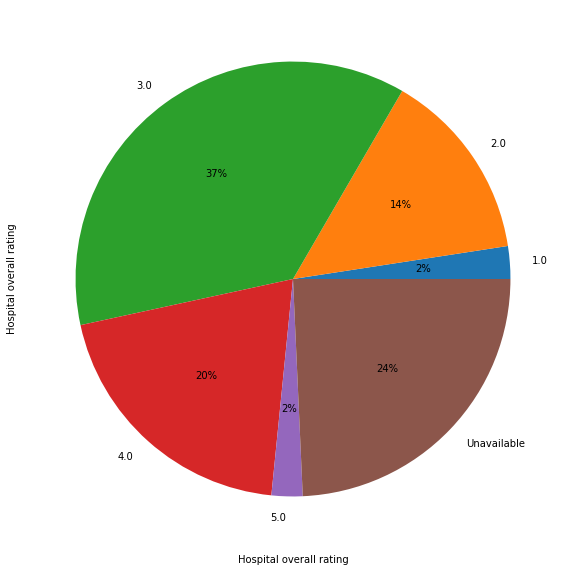

In [ ]:
# Plotting the target distribution

target_df = final_df[["Hospital overall rating"]]
target_df["Hospital overall rating"] = target_df["Hospital overall rating"].replace(np.NaN, "Unavailable")
target_df.groupby("Hospital overall rating")["Hospital overall rating"].count().plot(kind = "pie", figsize=(10,10), autopct='%1.f%%').set_xlabel('Hospital overall rating')

### We see that 24% of the target variable is unavailable/missing. These rows will be dropped before we begin the analysis.

In [ ]:
# Dropping rows where "Hospital overall rating" is missing
final_df = final_df.dropna(axis = 0, subset = ["Hospital overall rating"])

# Investigating categorical variables

In [ ]:
# Categorical column null percentage
final_df.select_dtypes(include= "O").isnull().mean().sort_values(ascending = False)*100

EDV_Sample                                                       100.000000
AMI_7a_Score                                                      99.972588
AMI_7a_Sample                                                     99.972588
OP_1_Score                                                        97.889254
OP_2_Score                                                        97.889254
OP_1_Sample                                                       97.889254
OP_2_Sample                                                       97.889254
Readmission national comparison footnote                          96.600877
CAC_3_Sample                                                      96.381579
CAC_3_Score                                                       96.381579
AMI_8a_Score                                                      96.080044
AMI_8a_Sample                                                     96.080044
Hospital overall rating footnote                                  95.285088
Effectivenes

We can see that some numeric columns have been classified as categorical columns because they contain symbols like: '$', '%', ','

Let's remove these symbols and convert these columns to numeric 

In [ ]:
# List of categorical columns
categorical_cols = ['State', 'Hospital Type', 'Hospital Ownership', 'Emergency Services', 'Meets criteria for meaningful use of EHRs', 
                    'Mortality national comparison','Safety of care national comparison', 'Readmission national comparison', 
                    'Patient experience national comparison', 'Effectiveness of care national comparison','Timeliness of care national comparison', 
                    'Efficient use of medical imaging national comparison','EDV_Score']


# List of categorical columns which are to be converted to numeric
to_numeric_cols = [i for i in list(final_df.select_dtypes(include= "O").columns) if i not in categorical_cols]


# Replacing symbols like ('$', '%', ',') with "" in "to_numeric_cols" list
final_df.loc[:,to_numeric_cols] = final_df[to_numeric_cols].apply(lambda x: x.astype('str').str.replace("$",""))
final_df.loc[:,to_numeric_cols] = final_df[to_numeric_cols].apply(lambda x: x.astype('str').str.replace("%",""))
final_df.loc[:,to_numeric_cols] = final_df[to_numeric_cols].apply(lambda x: x.astype('str').str.replace(",",""))


# Converting categorical columns that should have been numeric to numeric columns
final_df[to_numeric_cols] = final_df[to_numeric_cols].apply(pd.to_numeric, errors= "coerce")


# Imputing null values in categorical columns with 'unavailable'
final_df[categorical_cols] = final_df[categorical_cols].fillna("Unavailable")

In [ ]:
# Categorical columns null percentage
final_df.select_dtypes(include= "O").isnull().mean()

State                                                   0.0
Hospital Type                                           0.0
Hospital Ownership                                      0.0
Emergency Services                                      0.0
Meets criteria for meaningful use of EHRs               0.0
Mortality national comparison                           0.0
Safety of care national comparison                      0.0
Readmission national comparison                         0.0
Patient experience national comparison                  0.0
Effectiveness of care national comparison               0.0
Timeliness of care national comparison                  0.0
Efficient use of medical imaging national comparison    0.0
EDV_Score                                               0.0
dtype: float64

In [ ]:
final_df.select_dtypes(include= "O").describe()

,State,Hospital Type,Hospital Ownership,Emergency Services,Meets criteria for meaningful use of EHRs,Mortality national comparison,Safety of care national comparison,Readmission national comparison,Patient experience national comparison,Effectiveness of care national comparison,Timeliness of care national comparison,Efficient use of medical imaging national comparison,EDV_Score
count,3648,3648,3648,3648,3648,3648,3648,3648,3648,3648,3648,3648,3648
unique,53,2,10,2,2,4,4,4,4,4,4,4,5
top,CA,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Y,Same as the National average,Same as the National average,Same as the National average,Same as the National average,Same as the National average,Same as the National average,Same as the National average,Medium
freq,301,3061,1591,3538,3452,2618,1428,1853,1143,1997,1376,2027,968


We can see that *Meets criteria for meaningful use of EHRs* has only one useful value i.e it has low variance. Hence, dropping this column.

# Investigating Numerical Variables

In [ ]:
final_df.select_dtypes(include = "number").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3648 entries, 10001 to 650001
Columns: 293 entries, Hospital overall rating to PAYM_30_PN_Payment
dtypes: float64(293)
memory usage: 8.2 MB


In [ ]:
final_df.describe()

,Hospital overall rating,Hospital overall rating footnote,Mortality national comparison footnote,Safety of care national comparison footnote,Readmission national comparison footnote,Patient experience national comparison footnote,Effectiveness of care national comparison footnote,Timeliness of care national comparison footnote,Efficient use of medical imaging national comparison footnote,H_CLEAN_HSP_A_P_HCAHPS Answer Percent,H_CLEAN_HSP_SN_P_HCAHPS Answer Percent,H_CLEAN_HSP_U_P_HCAHPS Answer Percent,H_CLEAN_LINEAR_SCORE_HCAHPS Answer Percent,H_CLEAN_STAR_RATING_HCAHPS Answer Percent,H_COMP_1_A_P_HCAHPS Answer Percent,H_COMP_1_LINEAR_SCORE_HCAHPS Answer Percent,H_COMP_1_SN_P_HCAHPS Answer Percent,H_COMP_1_STAR_RATING_HCAHPS Answer Percent,H_COMP_1_U_P_HCAHPS Answer Percent,H_COMP_2_A_P_HCAHPS Answer Percent,H_COMP_2_LINEAR_SCORE_HCAHPS Answer Percent,H_COMP_2_SN_P_HCAHPS Answer Percent,H_COMP_2_STAR_RATING_HCAHPS Answer Percent,H_COMP_2_U_P_HCAHPS Answer Percent,H_COMP_3_A_P_HCAHPS Answer Percent,H_COMP_3_LINEAR_SCORE_HCAHPS Answer Percent,H_COMP_3_SN_P_HCAHPS Answer Percent,H_COMP_3_STAR_RATING_HCAHPS Answer Percent,H_COMP_3_U_P_HCAHPS Answer Percent,H_COMP_4_A_P_HCAHPS Answer Percent,H_COMP_4_LINEAR_SCORE_HCAHPS Answer Percent,H_COMP_4_SN_P_HCAHPS Answer Percent,H_COMP_4_STAR_RATING_HCAHPS Answer Percent,H_COMP_4_U_P_HCAHPS Answer Percent,H_COMP_5_A_P_HCAHPS Answer Percent,H_COMP_5_LINEAR_SCORE_HCAHPS Answer Percent,H_COMP_5_SN_P_HCAHPS Answer Percent,H_COMP_5_STAR_RATING_HCAHPS Answer Percent,H_COMP_5_U_P_HCAHPS Answer Percent,H_COMP_6_LINEAR_SCORE_HCAHPS Answer Percent,H_COMP_6_N_P_HCAHPS Answer Percent,H_COMP_6_STAR_RATING_HCAHPS Answer Percent,H_COMP_6_Y_P_HCAHPS Answer Percent,H_COMP_7_A_HCAHPS Answer Percent,H_COMP_7_D_SD_HCAHPS Answer Percent,H_COMP_7_LINEAR_SCORE_HCAHPS Answer Percent,H_COMP_7_SA_HCAHPS Answer Percent,H_COMP_7_STAR_RATING_HCAHPS Answer Percent,H_HSP_RATING_0_6_HCAHPS Answer Percent,H_HSP_RATING_7_8_HCAHPS Answer Percent,H_HSP_RATING_9_10_HCAHPS Answer Percent,H_HSP_RATING_LINEAR_SCORE_HCAHPS Answer Percent,H_HSP_RATING_STAR_RATING_HCAHPS Answer Percent,H_QUIET_HSP_A_P_HCAHPS Answer Percent,H_QUIET_HSP_SN_P_HCAHPS Answer Percent,H_QUIET_HSP_U_P_HCAHPS Answer Percent,H_QUIET_LINEAR_SCORE_HCAHPS Answer Percent,H_QUIET_STAR_RATING_HCAHPS Answer Percent,H_RECMND_DN_HCAHPS Answer Percent,H_RECMND_DY_HCAHPS Answer Percent,H_RECMND_LINEAR_SCORE_HCAHPS Answer Percent,H_RECMND_PY_HCAHPS Answer Percent,H_RECMND_STAR_RATING_HCAHPS Answer Percent,H_STAR_RATING_HCAHPS Answer Percent,H_CLEAN_HSP_A_P_Patient Survey Star Rating,H_CLEAN_HSP_SN_P_Patient Survey Star Rating,H_CLEAN_HSP_U_P_Patient Survey Star Rating,H_CLEAN_LINEAR_SCORE_Patient Survey Star Rating,H_CLEAN_STAR_RATING_Patient Survey Star Rating,H_COMP_1_A_P_Patient Survey Star Rating,H_COMP_1_LINEAR_SCORE_Patient Survey Star Rating,H_COMP_1_SN_P_Patient Survey Star Rating,H_COMP_1_STAR_RATING_Patient Survey Star Rating,H_COMP_1_U_P_Patient Survey Star Rating,H_COMP_2_A_P_Patient Survey Star Rating,H_COMP_2_LINEAR_SCORE_Patient Survey Star Rating,H_COMP_2_SN_P_Patient Survey Star Rating,H_COMP_2_STAR_RATING_Patient Survey Star Rating,H_COMP_2_U_P_Patient Survey Star Rating,H_COMP_3_A_P_Patient Survey Star Rating,H_COMP_3_LINEAR_SCORE_Patient Survey Star Rating,H_COMP_3_SN_P_Patient Survey Star Rating,H_COMP_3_STAR_RATING_Patient Survey Star Rating,H_COMP_3_U_P_Patient Survey Star Rating,H_COMP_4_A_P_Patient Survey Star Rating,H_COMP_4_LINEAR_SCORE_Patient Survey Star Rating,H_COMP_4_SN_P_Patient Survey Star Rating,H_COMP_4_STAR_RATING_Patient Survey Star Rating,H_COMP_4_U_P_Patient Survey Star Rating,H_COMP_5_A_P_Patient Survey Star Rating,H_COMP_5_LINEAR_SCORE_Patient Survey Star Rating,H_COMP_5_SN_P_Patient Survey Star Rating,H_COMP_5_STAR_RATING_Patient Survey Star Rating,H_COMP_5_U_P_Patient Survey Star Rating,H_COMP_6_LINEAR_SCORE_Patient Survey Star Rating,H_COMP_6_N_P_Patient Survey Star Rating,H_COMP_6_STAR_RATING_Patient Survey Star Rating,H_COMP_

In [ ]:
# Numeric column null percentage
final_df.select_dtypes(include= "number").isnull().mean().sort_values(ascending = False)*100

H_COMP_5_SN_P_HCAHPS Linear Mean Value                           100.000000
Patient experience national comparison footnote                  100.000000
H_COMP_3_SN_P_HCAHPS Linear Mean Value                           100.000000
H_COMP_3_A_P_HCAHPS Linear Mean Value                            100.000000
H_COMP_2_U_P_HCAHPS Linear Mean Value                            100.000000
H_COMP_2_STAR_RATING_HCAHPS Linear Mean Value                    100.000000
H_COMP_2_SN_P_HCAHPS Linear Mean Value                           100.000000
H_COMP_2_A_P_HCAHPS Linear Mean Value                            100.000000
H_COMP_1_U_P_HCAHPS Linear Mean Value                            100.000000
H_COMP_1_STAR_RATING_HCAHPS Linear Mean Value                    100.000000
H_COMP_1_SN_P_HCAHPS Linear Mean Value                           100.000000
H_COMP_1_A_P_HCAHPS Linear Mean Value                            100.000000
H_CLEAN_STAR_RATING_HCAHPS Linear Mean Value                     100.000000
H_CLEAN_HSP_

In [ ]:
nulls = round(final_df.isnull().mean()*100)
all_null_cols = list(nulls[nulls == 100].index)

# Dropping columns with 100% null values
final_df = final_df.drop(all_null_cols, axis = 1)

In [ ]:
final_df.to_pickle('hospital_final_df.gzip')

# EDA

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3648 entries, 10001 to 650001
Columns: 185 entries, State to PAYM_30_PN_Payment
dtypes: float64(172), object(13)
memory usage: 5.2+ MB


In [ ]:
# Checking for correlations and selecting column-pairs with greater than or equal to 0.85 correlation
dataCorr = final_df[sorted(final_df.columns)].corr()
dataCorr = dataCorr[abs(dataCorr) >= 0.85].stack().reset_index()
dataCorr = dataCorr[dataCorr['level_0'].astype(str)!=dataCorr['level_1'].astype(str)].sort_values(by=['level_1'], ascending=False).reset_index(drop=True)
 
# Filtering out lower/upper triangular duplicates 
dataCorr['ordered-cols'] = dataCorr.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)
dataCorr = dataCorr.drop_duplicates(['ordered-cols']).drop(['ordered-cols'], axis=1)
 
final_dataCorr = dataCorr.sort_values(by=['level_0'], ascending=False).reset_index(drop=True)
final_dataCorr

,level_0,level_1,0
0,VTE_3_Sample,VTE_5_Sample,0.977517
1,STK_6_Sample,STK_8_Sample,0.977473
2,STK_5_Sample,STK_6_Sample,0.970232
3,STK_5_Sample,STK_8_Sample,0.944099
4,STK_3_Sample,STK_8_Sample,0.858001
5,STK_3_Sample,STK_5_Sample,0.876582
6,STK_3_Sample,STK_6_Sample,0.894424
7,STK_2_Sample,STK_6_Sample,0.985293
8,STK_2_Sample,STK_5_Sample,0.985169
9,STK_2_Sample,STK_3_Sample,0.908366


# Plotting Categorical Variables

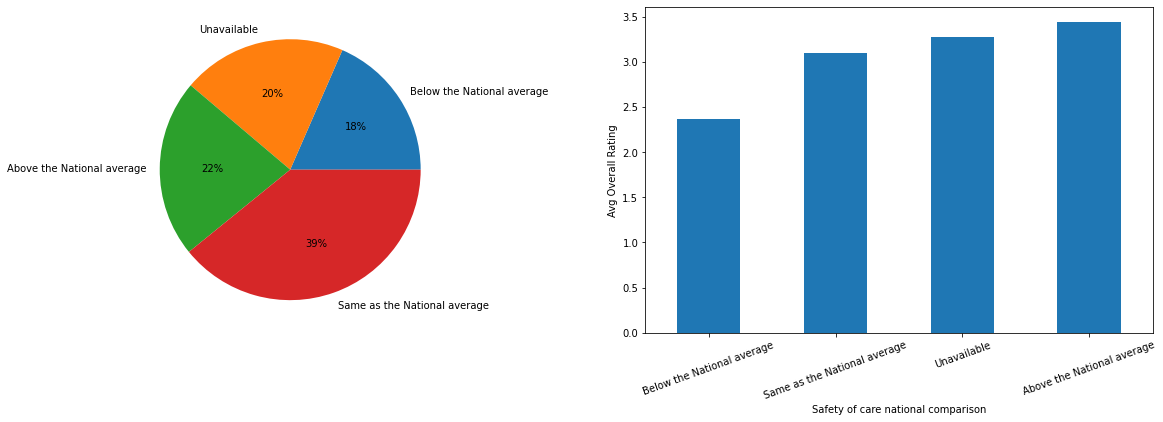

In [ ]:
plot_categorical(final_df,"Safety of care national comparison","Hospital overall rating",label_rotation=20,combine_less_freq_segments_pct = 3)

Hospitals with safety of care below the national average tend to have a lower average overall rating compared to hospitals above the national average

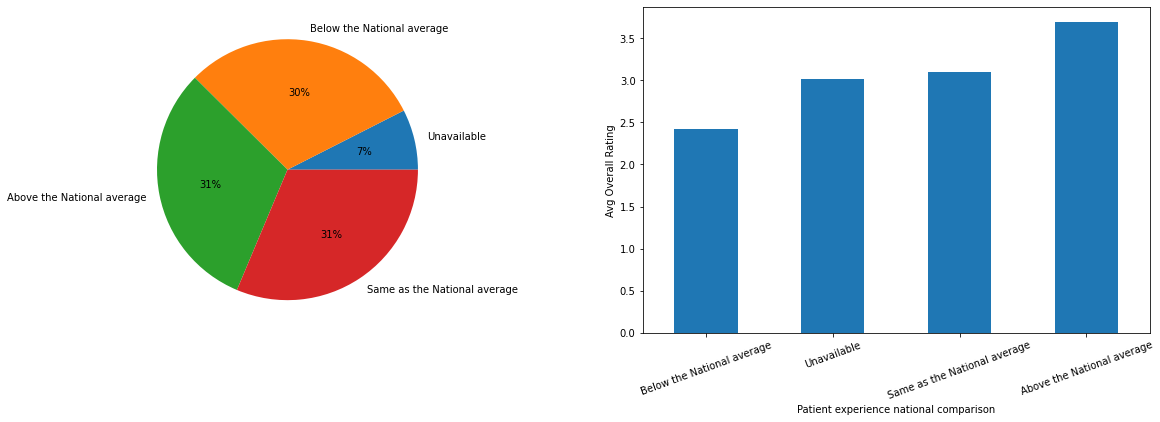

In [ ]:
plot_categorical(final_df,"Patient experience national comparison","Hospital overall rating",label_rotation=20,combine_less_freq_segments_pct = 3)

Hospitals with *patient experience* below the national average tend to have a lower average overall rating compared to hospitals above the national average

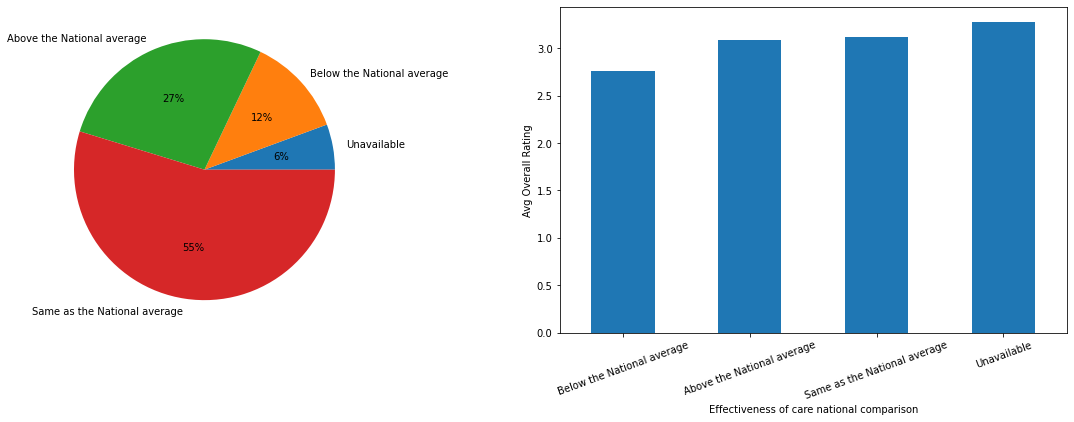

In [ ]:
plot_categorical(final_df,"Effectiveness of care national comparison","Hospital overall rating",label_rotation=20,combine_less_freq_segments_pct = 3)

Hospitals with *effectiveness of care* below the national average tend to have a lower average overall rating compared to hospitals above the national average

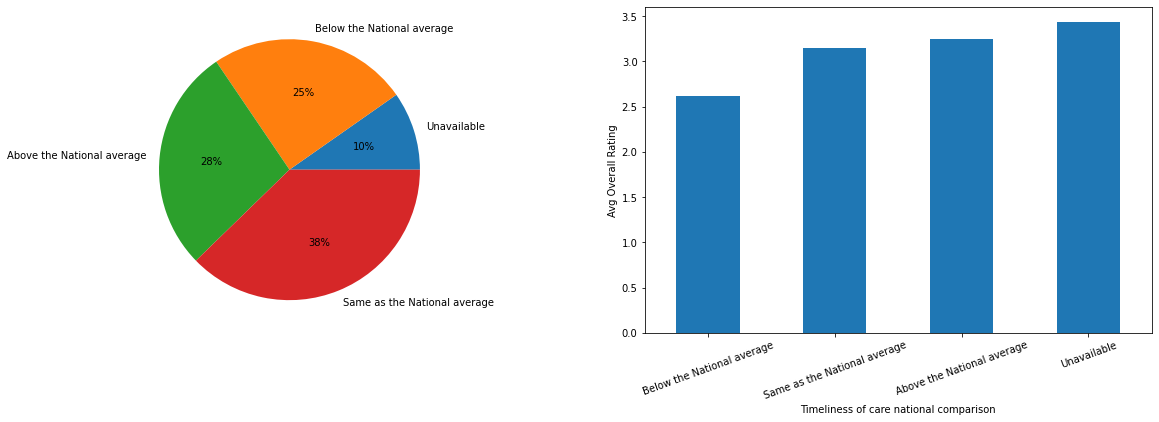

In [ ]:
plot_categorical(final_df,"Timeliness of care national comparison","Hospital overall rating",label_rotation=20,combine_less_freq_segments_pct = 3)

Hospitals with *timeliness of care* below the national average tend to have a lower average overall rating compared to hospitals above the national average

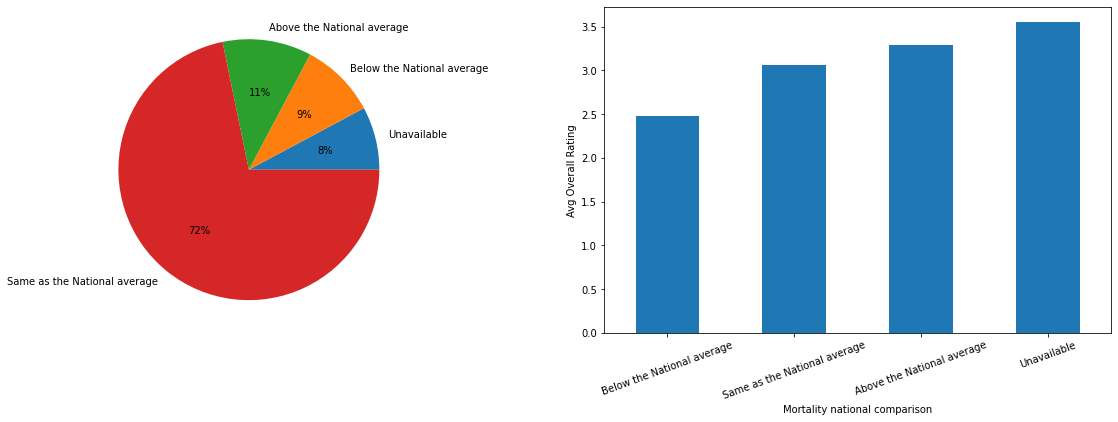

In [ ]:
plot_categorical(final_df,"Mortality national comparison","Hospital overall rating",label_rotation=20,combine_less_freq_segments_pct = 3)

Hospitals with *mortality rate* below the national average tend to have a lower average overall rating compared to hospitals above the national average

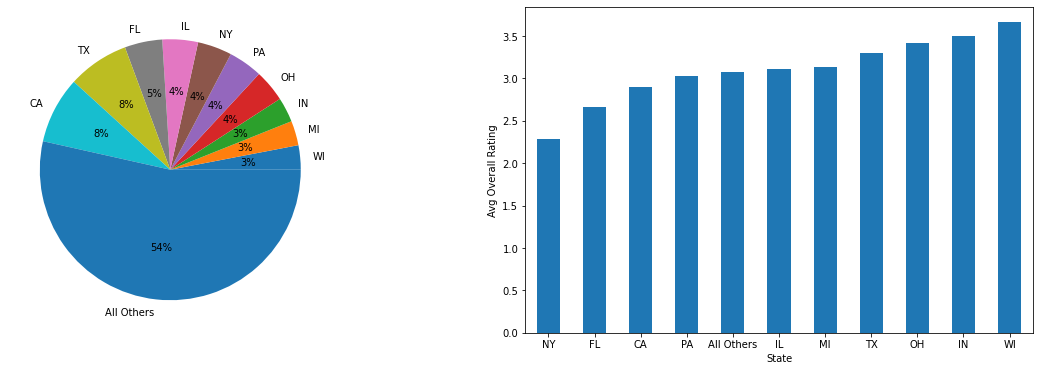

In [ ]:
plot_categorical(final_df,"State","Hospital overall rating",label_rotation=0,combine_less_freq_segments_pct = 3)

Hospitals in states like New York, Florida and California tend to have a lower average overall rating whereas hospitals in states like Wisconsin, Indiana and Ohio tend to have a higher average overall rating

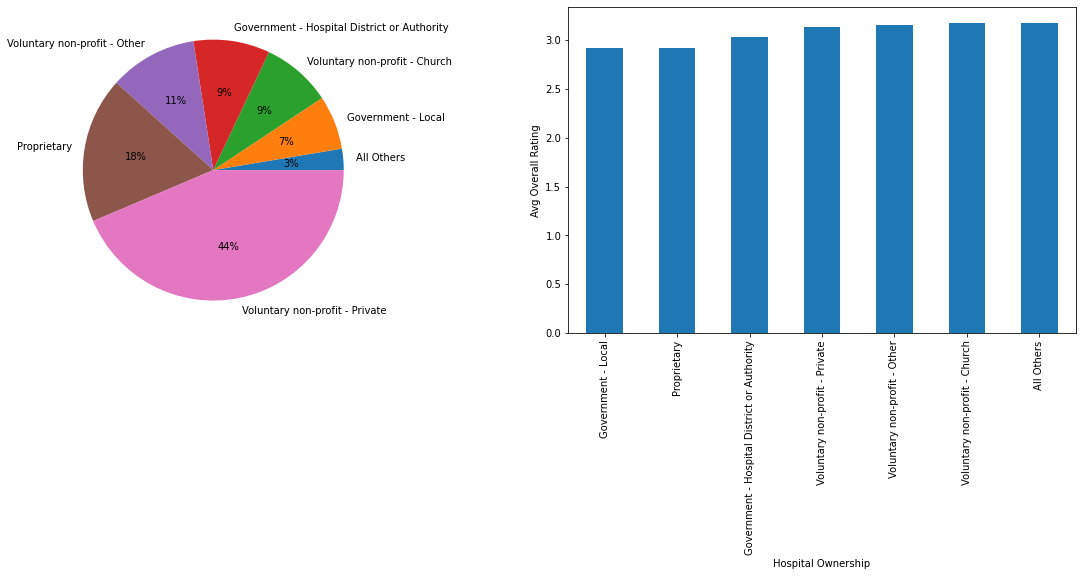

In [ ]:
plot_categorical(final_df,"Hospital Ownership","Hospital overall rating",label_rotation=90,combine_less_freq_segments_pct = 3)

*Government - Local* and *Proprietary* hospitals have slightly lower average overall rating compared to the remaining 

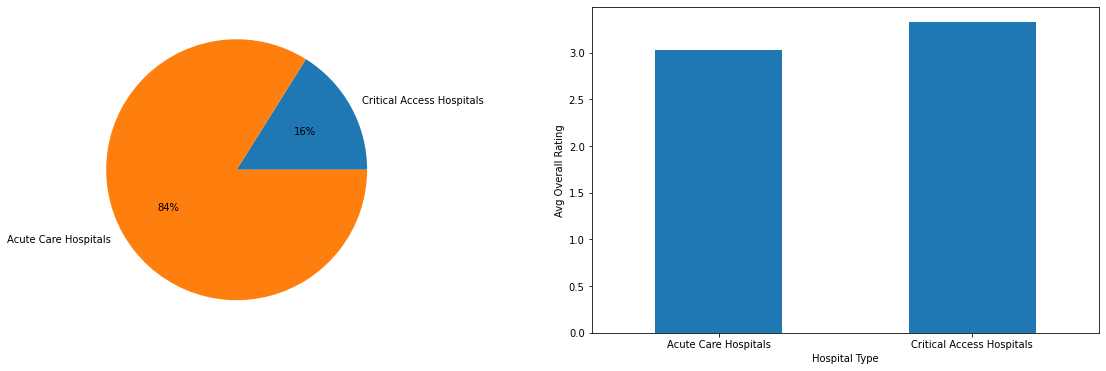

In [ ]:
plot_categorical(final_df,"Hospital Type","Hospital overall rating",label_rotation=0,combine_less_freq_segments_pct = 0)

*Acute Care* Hospitals have slightly lower average overall rating compared to *Critical Access* Hospitals

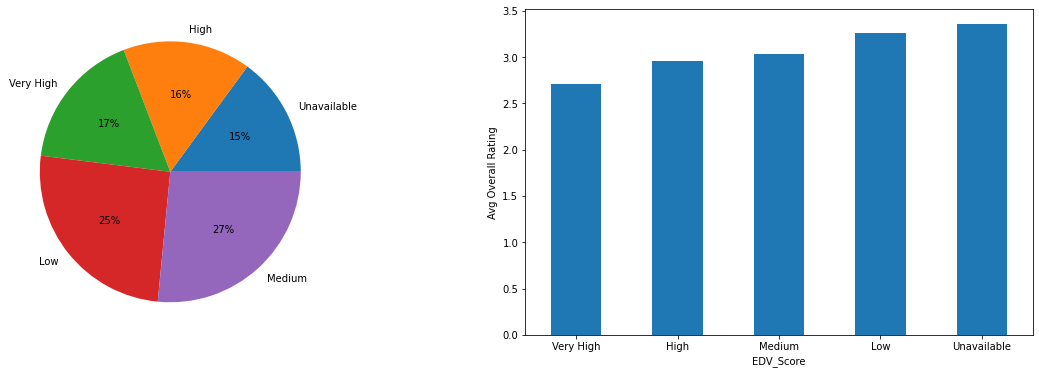

In [ ]:
plot_categorical(final_df,"EDV_Score","Hospital overall rating",label_rotation=0,combine_less_freq_segments_pct = 0)

*EDV_Score* - Emergency Department Volume

Hospitals with very high Emergency Department Volume tend to have a lower rating

# Plotting Numerical Variables

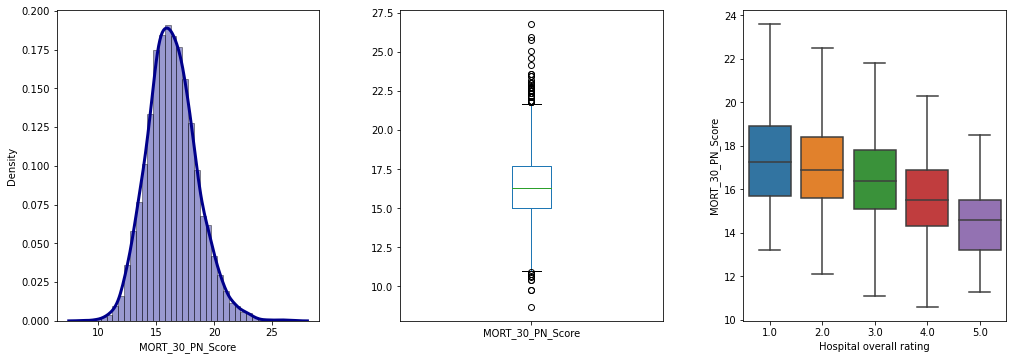

In [ ]:
plot_numerical(final_df,'MORT_30_PN_Score','Hospital overall rating')

**MORT_30_PN_Score**

MORT_30_PN : Pneumonia (PN) 30-Day Mortality Rate

Hospitals with a higher percentage of people dying of pneumonia within 30-days of discharge date tend to have a low overall rating

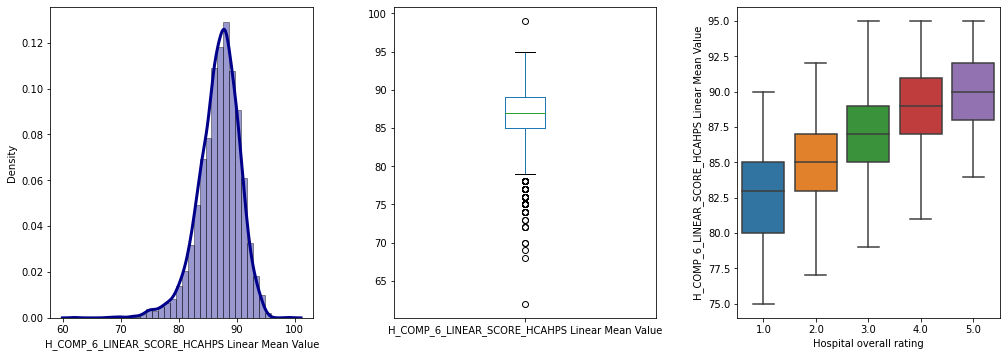

In [ ]:
plot_numerical(final_df,'H_COMP_6_LINEAR_SCORE_HCAHPS Linear Mean Value','Hospital overall rating')

**H_COMP_6_LINEAR_SCORE_HCAHPS Linear Mean Value**

H_COMP_6_LINEAR_SCORE : Discharge information - linear mean score

Hospitals with a higher *Discharge information - linear mean score* tend to have a higher overall rating

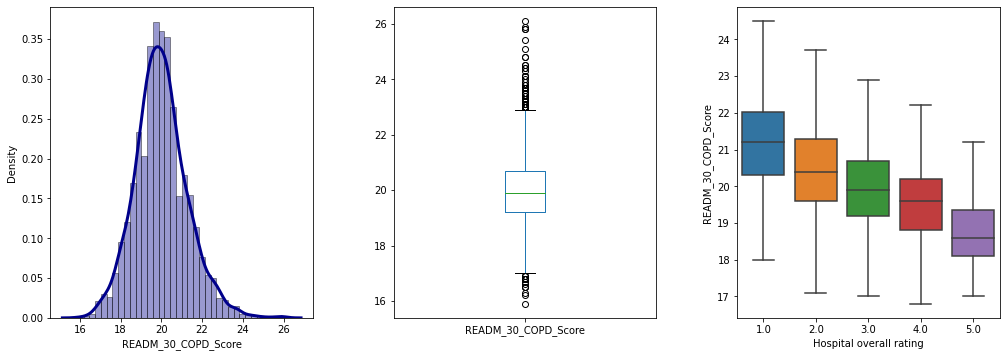

In [ ]:
plot_numerical(final_df,'READM_30_COPD_Score','Hospital overall rating')

**READM_30_COPD_Score**

READM_30_COPD	: Rate of readmission for chronic obstructive pulmonary disease (COPD) patients

Hospitals with a higher percentage of readmissions of chronic obstructive pulmonary disease (COPD) patients withinin 30 days of discharge date tend to have a low overall rating

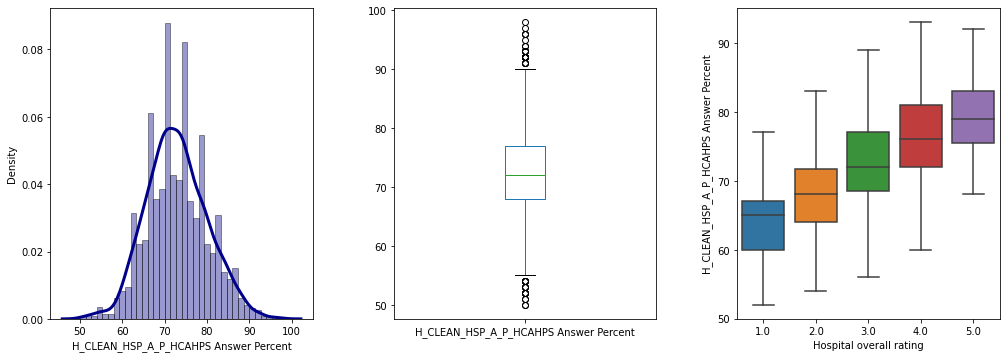

In [ ]:
plot_numerical(final_df,'H_CLEAN_HSP_A_P_HCAHPS Answer Percent','Hospital overall rating')

**H_CLEAN_HSP_A_P_HCAHPS Answer Percent**

H_CLEAN_HSP_A_P :	Room was *always* clean

Hospitals with a higher percentage of responses to the question "Was the room always clean?" tend to have a higher overall rating

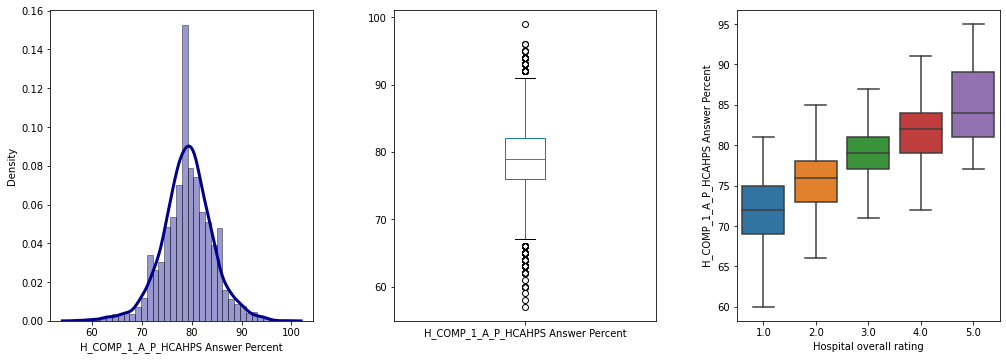

In [ ]:
plot_numerical(final_df,'H_COMP_1_A_P_HCAHPS Answer Percent','Hospital overall rating')

**H_COMP_1_A_P_HCAHPS Answer Percent**

H_COMP_1_A_P : Nurses *always* communicated well

Hospitals with a higher percentage of responses to the question "Do nurses always communicate well?" tend to have a higher overall rating

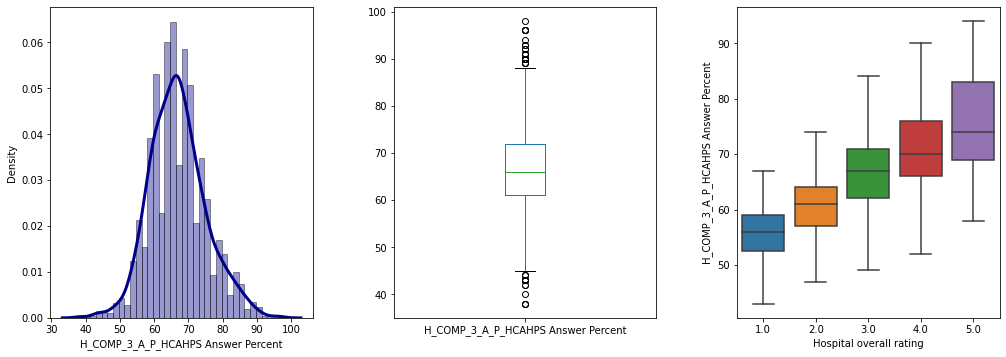

In [ ]:
plot_numerical(final_df,'H_COMP_3_A_P_HCAHPS Answer Percent','Hospital overall rating')

**H_COMP_3_A_P_HCAHPS Answer Percent**

H_COMP_3_A_P : Patients *always* received help as soon as they wanted

Hospitals with a higher percentage of responses to the question "Do patients always receive help as soon as they want?" tend to have a higher overall rating

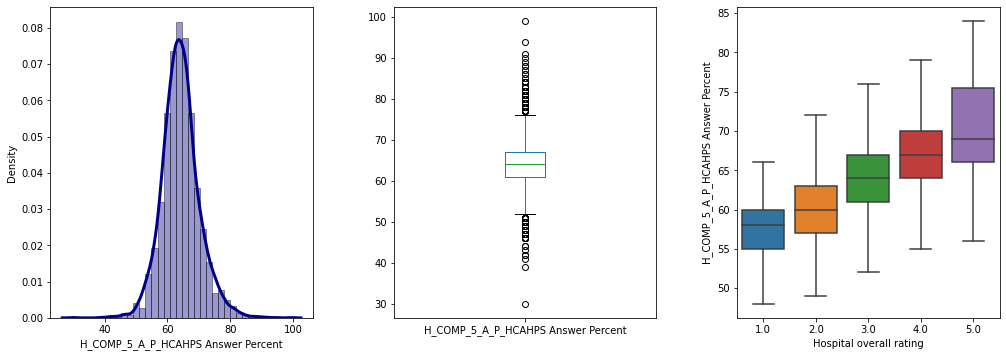

In [ ]:
plot_numerical(final_df,'H_COMP_5_A_P_HCAHPS Answer Percent','Hospital overall rating')

**H_COMP_5_A_P_HCAHPS Answer Percent**

H_COMP_5_A_P : Staff *always* explained

Hospitals with a higher percentage of responses to the question "Does the staff always explain?" tend to have a higher overall rating

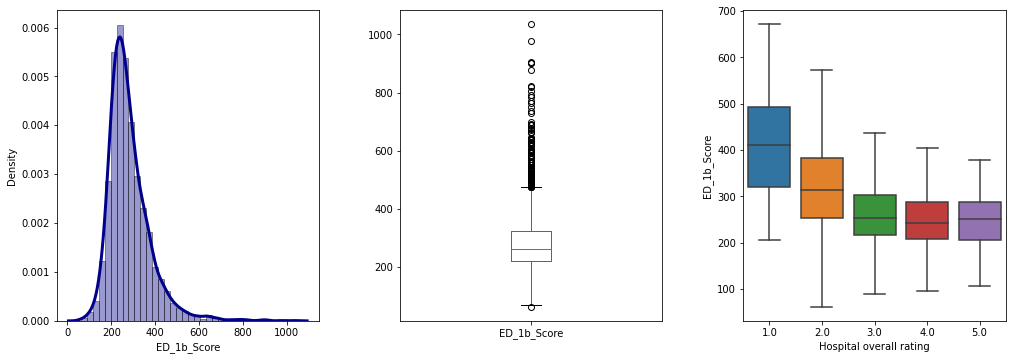

In [ ]:
plot_numerical(final_df,'ED_1b_Score','Hospital overall rating')

**ED_1b_Score**

ED_1b :	ED1_Emergency Department

Hospitals with a higher *ED_1b_Score* tend to have a low overall rating

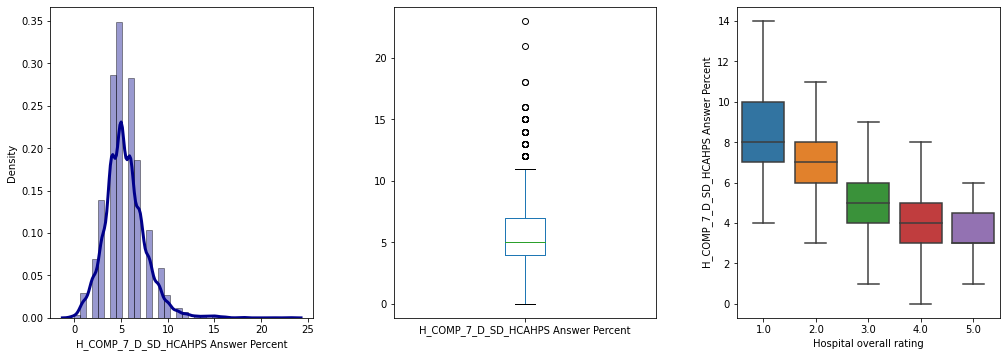

In [ ]:
plot_numerical(final_df,'H_COMP_7_D_SD_HCAHPS Answer Percent','Hospital overall rating')

**H_COMP_7_D_SD_HCAHPS Answer Percent**

H_COMP_7_D_SD	: Patients who *Disagree* or *Strongly Disagree* whether they understood their care when they left the hospital

Hospitals with a higher percentage of patients who do not understand their care when they leave the hospital tend to have a low overall rating

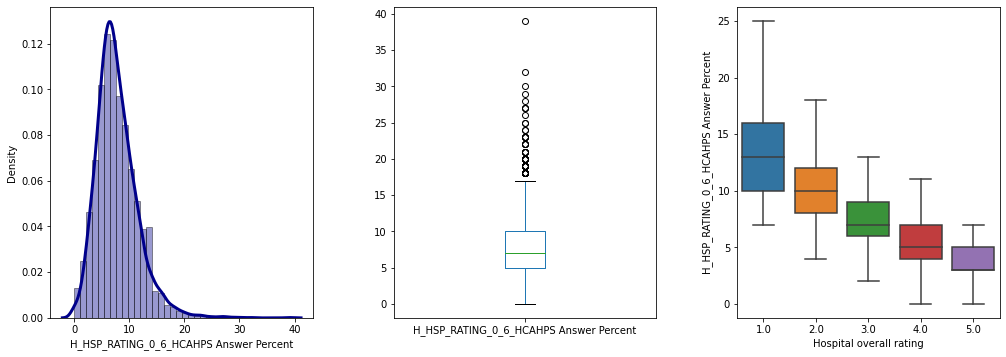

In [ ]:
plot_numerical(final_df,'H_HSP_RATING_0_6_HCAHPS Answer Percent','Hospital overall rating')

**H_HSP_RATING_0_6_HCAHPS Answer Percent**

H_HSP_RATING_0_6 : Patients who gave a rating of "6" or lower (low)

Hospitals with a higher percentage of patients giving a rating of "6" or lower tend to have a low overall rating

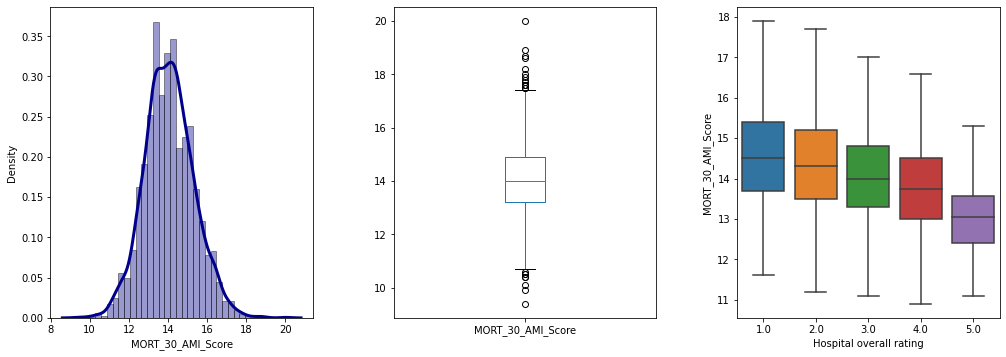

In [ ]:
plot_numerical(final_df,'MORT_30_AMI_Score','Hospital overall rating')

**MORT_30_AMI_Score**

MORT_30_AMI	: Acute Myocardial Infarction (heart attack) 30-Day Mortality Rate

Hospitals with a higher percentage of people dying of *Acute Myocardial Infarction* (heart attack) within 30-days of discharge date tend to have a low overall rating

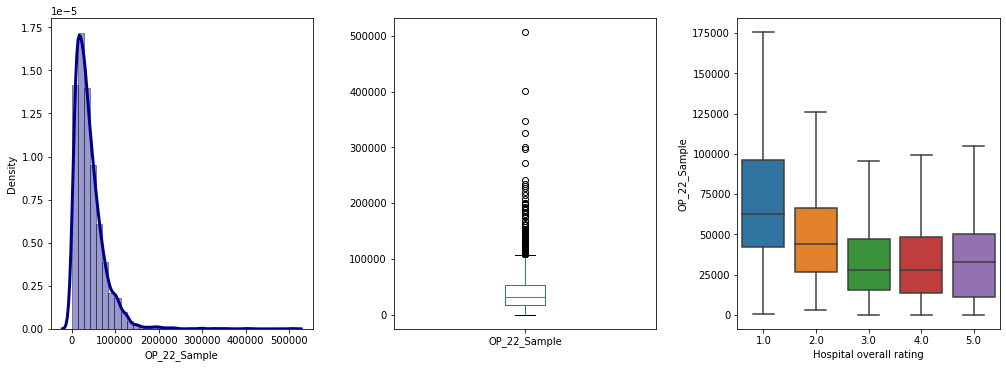

In [ ]:
plot_numerical(final_df,'OP_22_Sample','Hospital overall rating')

**P_22_Sample**

OP_22 :	Left before being seen_Emergency Department

Hospitals with a higher number of people who needed to be seen by the Emergency Department and left without being seen by them, tend to have a low rating

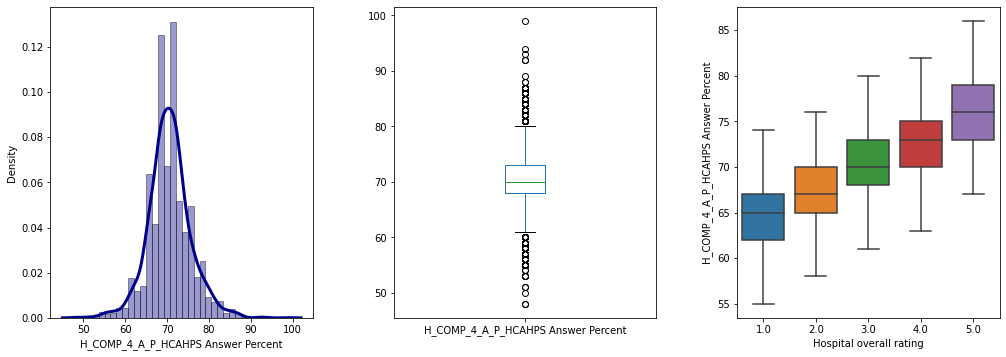

In [ ]:
plot_numerical(final_df,'H_COMP_4_A_P_HCAHPS Answer Percent','Hospital overall rating')

**H_COMP_4_A_P_HCAHPS Answer Percent**

H_COMP_4_A_P : Pain was *always* well controlled

Hospitals with a higher percentage of responses to the question "Was pain always well controlled?" tend to have a higher overall rating

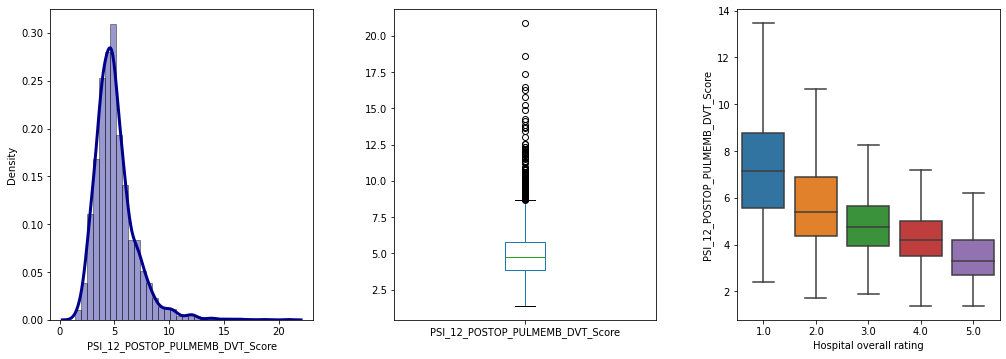

In [ ]:
plot_numerical(final_df,'PSI_12_POSTOP_PULMEMB_DVT_Score','Hospital overall rating')

**PSI_12_POSTOP_PULMEMB_DVT_Score**

PSI_12_POSTOP_PULMEMB_DVT : Serious blood clots after surgery

Hospitals with higher higher number of people suffering from serious blood clots after surgery tend to have a low overall rating

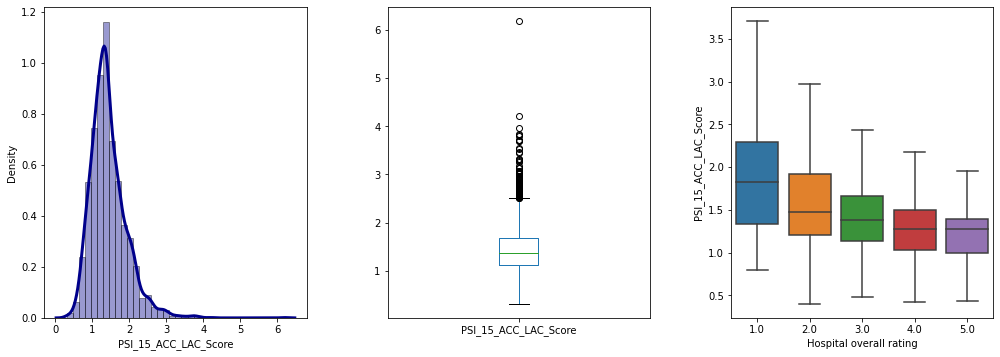

In [ ]:
plot_numerical(final_df,'PSI_15_ACC_LAC_Score','Hospital overall rating')

**PSI_15_ACC_LAC_Score**

PSI_15_ACC_LAC : Accidental cuts and tears from medical treatment

Hospitals with higher number of people with accidental cuts and tears from medical treatment tend to have a low overall rating

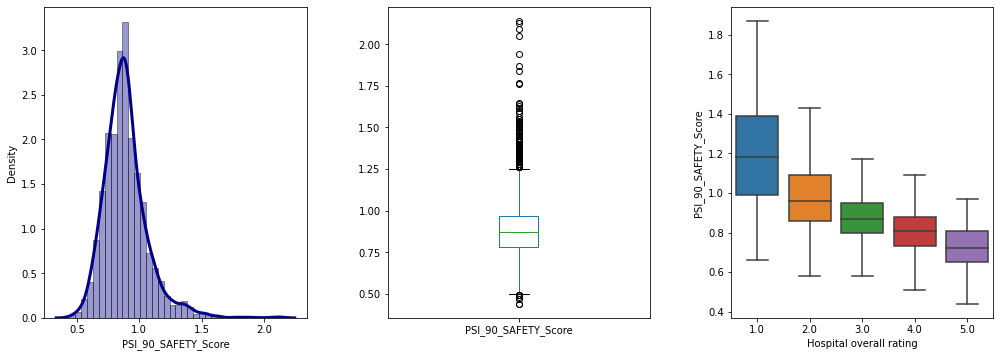

In [ ]:
plot_numerical(final_df,'PSI_90_SAFETY_Score','Hospital overall rating')

**PSI_90_SAFETY_Score**

PSI_90_SAFETY : Serious complications

Hospitals with higher number of people suffering from serious medical complications during the course of their medical treatment tend to have a low overall rating

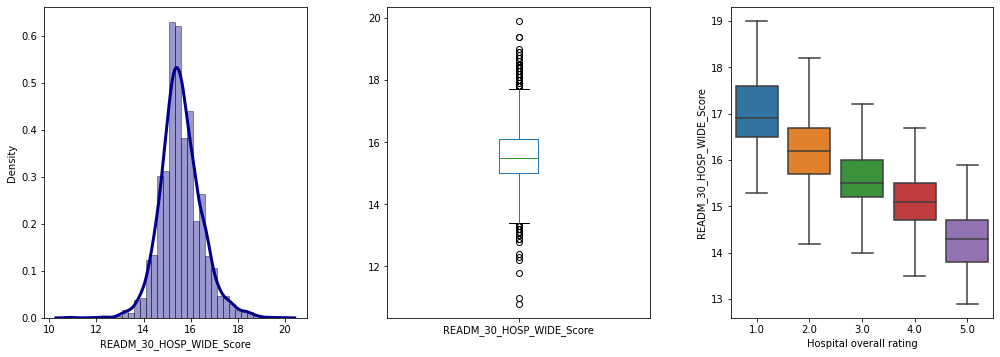

In [ ]:
plot_numerical(final_df,'READM_30_HOSP_WIDE_Score','Hospital overall rating')

**READM_30_HOSP_WIDE_Score**

READM_30_HOSP_WIDE : Rate of readmission after discharge from hospital (hospital-wide)

Hospitals with a higher percentage of readmission after discharge from hospital (hospital-wide) tend to have a low overall rating

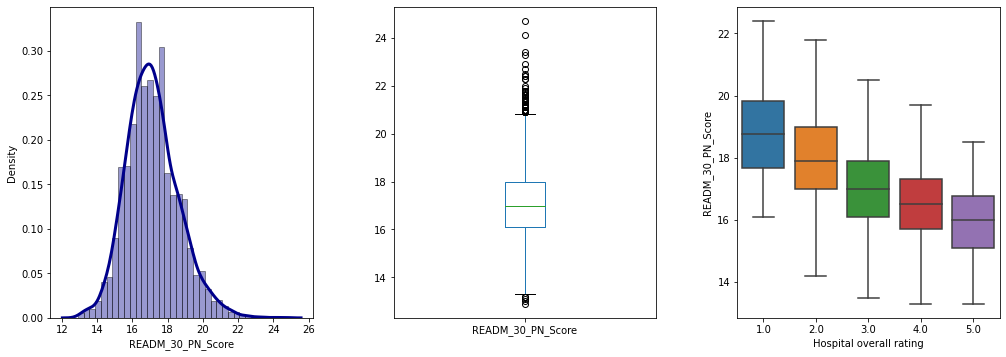

In [ ]:
plot_numerical(final_df,'READM_30_PN_Score','Hospital overall rating')

**READM_30_PN_Score**

READM_30_PN : Pneumonia (PN) 30-Day Readmission Rate

Hospitals with a higher percentage of readmission of patients with pneumonia within 30 days of discharge date tend to have a low overall rating

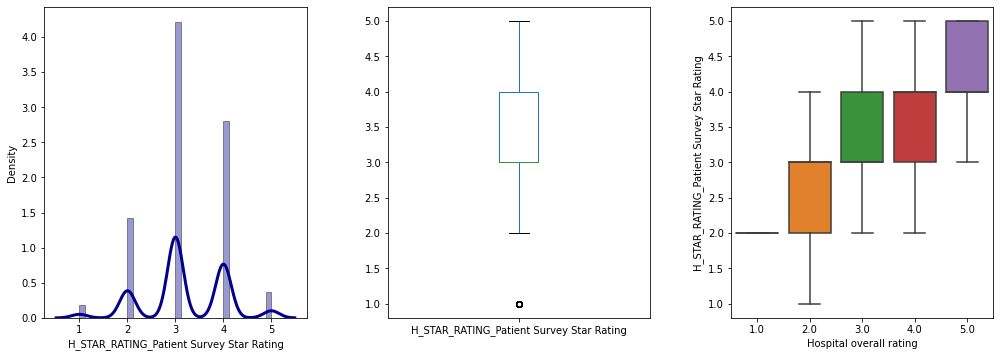

In [ ]:
plot_numerical(final_df,'H_STAR_RATING_Patient Survey Star Rating','Hospital overall rating')

**H_STAR_RATING_Patient Survey Star Rating**

H_STAR_RATING	: Summary star rating

Hospitals with higher *summary star rating* tend to have a higher overall rating

# Fin!